In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt


from ethogram.build_ethogram_df.Experiments import Experiments
from ethogram.build_ethogram_df.Fish import Fish
from ethogram.build_ethogram_df.ImportShader import ShaderPreprocessing
from ethogram.build_ethogram_df.ImportTracking import TrackingPreprocessing
from ethogram.build_ethogram_df.Ethogram import Ethogram

from ethogram.build_ethogram_df.Stimuli import EthogramStimuliProcessing
from ethogram.build_ethogram_df.Tracking import EthogramTrackingProcessing

from ethogram.build_ethogram_df.Stimuli import EthogramStimuliProcessing

from ethogram.utils import smallestenclosingcircle
from ethogram.utils.auxfun_df import find_onset_offset,find_onset_cat_sign
from ethogram.utils.auxfun_bouts import JoaoColormap,GetBoutsName,convert_to_13, convert_to_26 

from ethogram.utils.plotting import display_trajectory_in_circle,display_stimuli,plot_columns
from ethogram.utils.plotting import display_bouts_histogram,display_bouts_bar,display_bouts_arrow,display_bouts_trials


In [3]:
strain = 'Tu'

data_folder='G:/ExperimentalData'
protocol_name='CatchAllBouts'

experiments = Experiments(data_folder,protocol_name)
experiments_df = experiments.table

fps_index=700
arduino_col =['frame_id','tmp','beep','tmp','frequency','tmp','duration','tmp','rotifer']

############################################################################################
# THE ORDER OF THE DICT MATTERS (ERROR IF APPROACHING BEFORE LOOMING > IT SHOULD NOT MATTER
############################################################################################
discrete_visual_stim = {'UniformLight': ['color'],
                    'ForwardOMR': ['grating_speed'],
                    'LoomingDot':['loom_direction'],
                    'ApproachingDot':['dot_direction'],
                    'RotationOMR': ['grating_direction','grating_speed']}

continuous_visual_stim = {'UniformLight': [],
                    'ForwardOMR': ['cumulative_forward_swim_mm'],
                    'LoomingDot':[],
                    'ApproachingDot': [],
                    'RotationOMR':[]}
shader_list = [s for s in discrete_visual_stim.keys()]

discrete_acoustic_stim = {'Beep': ['duration','frequency','PreyCapture']}
default_uniforms=['frame_id','iGlobalTime','fish_pos_x_mm','fish_pos_y_mm','fish_orientation']

##########################################################################################################
# Dictionnary: Trial => Stim => Condition (column) => Value => Onset/Offset
trials={}

trials['Beep'] = {'column':'non_visual_stimuli_beep_frequency', 'value':[100,600],'interval_margin':[0,0]}
trials['Prey'] = {'column':'non_visual_stimuli_prey_capture_rotifer', 'value':[1],'interval_margin':[-3*60,0]}
trials['ApproachingDot'] = {'column':'visual_stimuli_ApproachingDot_dot_direction','value':[-90,90],'interval_margin':[-3,0]}
trials['LoomingDot'] = {'column':'visual_stimuli_LoomingDot_loom_direction','value':[-90,90],'interval_margin':[-1,0]}
trials['RotationOMR'] = {'column':'visual_stimuli_RotationOMR_grating_direction','value':[0, 45, 90, 135, 180, 225, 270, 315],'interval_margin':[-3,0]}
trials['LightDark'] = {'column':'visual_stimuli_UniformLight_color','value':[0],'interval_margin':[0,2]}
trials['ForwardOMR'] = {'column':'visual_stimuli_ForwardOMR_grating_speed','value':[ 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],'interval_margin':[-1,0]}

stim = EthogramStimuliProcessing()
tracking = EthogramTrackingProcessing()


In [4]:
def compute_mid_bout_indicator(bout_indicator,Min_Bout_Duration=90):
    
    onset,offset,duration = find_onset_offset_numpy(bout_indicator)
    mid_bout_indicator = np.copy(bout_indicator)

    for on_,off_,d_ in zip(onset,offset,duration):
        if (d_>2*Min_Bout_Duration) :#& (on_+Min_Bout_Duration<len(bout_indicator)) &(off_-Min_Bout_Duration>0):
            mid_bout_indicator[on_:on_+Min_Bout_Duration] = 0
            mid_bout_indicator[off_-Min_Bout_Duration:off_] = 0
        else:
            mid_bout_indicator[on_:off_] = 0
    
    return mid_bout_indicator

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [5]:
from scipy.signal import savgol_filter

def compute_noiselevel(tail_angle,win = 15):

    # Compute rolling R2:
    
    # Compute residual with smooth version as measure of noise:
    x_smooth = savgol_filter(tail_angle,win, 2)    

    residual = np.power(tail_angle - x_smooth,2)
    mean_res = pd.DataFrame({ 'x':residual })
    mean_res = mean_res.rolling(win).mean()
    mean_res = mean_res.x.values

    mean_var = pd.DataFrame({ 'x':tail_angle })
    mean_var = mean_var.rolling(win).var()
    mean_var = mean_var.x.values

    R2 = 1 - mean_res/mean_var

    # Median R2:
    df = pd.DataFrame({ 'x':R2 })
    df = df.rolling(win).median()           # version 0.18.0 syntax
    median_R2 = df.x.values
    
    return median_R2

In [6]:
experiments_df.head(3)

,expe_name,path,name_of_experiment,setup,date,time,strain,tank,age,pixel_size,arena_size,width,height,fps,ratio_arena_vs_screen,file_signature
0,CatchAllBouts_atlas_20200525_1139,G:/ExperimentalData\CatchAllBouts,CatchAllBouts,atlas,20200525,1139,Danionella,0000,19,60.029907,50.0,948,948,700,0.9,000_camlog.txt
1,CatchAllBouts_atlas_20200525_1551,G:/ExperimentalData\CatchAllBouts,CatchAllBouts,atlas,20200525,1551,Tu,0478,5,60.029907,50.0,948,948,700,0.9,000_camlog.txt
2,CatchAllBouts_atlas_20200526_1446,G:/ExperimentalData\CatchAllBouts,CatchAllBouts,atlas,20200526,1446,Tu,0478,6,60.029907,50.0,948,948,700,0.9,000_camlog.txt


In [7]:
import smallestenclosingcircle

def compute_outer_circle(x,y,interval=100):
    p= [(x[i],y[i]) for i in np.arange(0,len(x),interval)]
    Circle = smallestenclosingcircle.make_circle(p)
    xc=Circle[0]
    yc=Circle[1]
    radius=Circle[2]
    return (xc,yc,radius)    


def display_trajectory(df,index,past_memory=3*700):
    #set up the figure
    fig = plt.figure(figsize=(5,5))
    canvas_width, canvas_height = fig.canvas.get_width_height()
    ax = fig.add_subplot()
    circle = plt.Circle((0, 0),25, ec='r', fill=False)
    ax.add_artist(circle)

    df_past = df.iloc[max(0,index-past_memory):index+1]
    ax.scatter(df_past['x'], df_past['y'], c = 'r', s =1,alpha=0.1)
    for i in range(0,df_past.shape[0],100):
        c = 1*np.cos(df_past.iloc[i]['angle'])
        s = 1*np.sin(df_past.iloc[i]['angle'])
        x_end = df_past.iloc[i]['x']
        y_end = df_past.iloc[i]['y']
        ax.arrow(x_end,y_end,c,s, head_width=1, head_length=1, fc='k', ec='k')

    c = 3*np.cos(df.iloc[index]['angle'])
    s = 3*np.sin(df.iloc[index]['angle'])
    x_end = df.iloc[index]['x']
    y_end = df.iloc[index]['y']
    ax.arrow(x_end,y_end,c,s, head_width=1, head_length=1, fc='b', ec='b')
    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)
    return fig


In [8]:
for i_fish in range(experiments_df.shape[0]):
    fish = experiments.get_fish(i_fish)
    print(i_fish)
    if fish.strain=='Tu':

        # LOAD FISH
        shader_preprocessing = ShaderPreprocessing(shader_list,discrete_visual_stim,continuous_visual_stim,default_uniforms)
        tracking_preprocessing = TrackingPreprocessing(fish,position_column=['fish_blob_l','fish_blob_c'],angle_column='body_angle_cart')
        ethogram = Ethogram(fish,shader_preprocessing,tracking_preprocessing,discrete_acoustic_stim,arduino_col)
        ethogram_df_flat = ethogram.flatten()
        ethogram_df_flat = tracking.append_edge_to_ethogram(ethogram_df_flat,fish)
        cam_log = fish.load_mat_camlog()
        bout_log = fish.load_mat_boutslog()
        matlab_onset = bout_log['trueboutstarts']
        arduino_df = fish.load_arduinolog(arduino_col)
        
        # Tail Angle:
        NumSegment = sum(['tail_angle' in cam_log.columns[i] for i in range(len(cam_log.columns))])
        tail_angle_raw = cam_log[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]

        # Trajectory:
        x = cam_log['mideye_x_cart'].values*fish.pixel_size/1000
        y = cam_log['mideye_y_cart'].values*fish.pixel_size/1000
        body_angle = cam_log['body_angle_cart'].values
        body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
                
        circle = compute_outer_circle(x,y)
        x_mideye,y_mideye = x-circle[0],y-circle[1]

        x = cam_log['fish_blob_c'].values*fish.pixel_size/1000
        y = -cam_log['fish_blob_l'].values*fish.pixel_size/1000
        circle = compute_outer_circle(x,y)
        x_blob,y_blob = x-circle[0],y-circle[1]


        # Bout Category:
        tail_active = np.zeros(cam_log.shape[0])
        bout_cat_matlab = np.zeros(cam_log.shape[0])
        bout_sign_matlab = np.zeros(cam_log.shape[0])

        onset = bout_log['trueboutstarts']
        offset = bout_log['indRealEnds']
        for i,(on_,off_) in enumerate(zip(onset,offset)):
            tail_active[on_:off_] = 1
            bout_cat_matlab[on_:off_] = np.sign(bout_log['BoutKinematicParameters'][i,85])
            bout_sign_matlab[on_:off_] = bout_log['boutCat'][i]

        # Merge in dataframe:

        df_traj=pd.DataFrame(np.vstack((x_blob,y_blob,x_mideye,y_mideye,body_angle)).T, columns=['x_blob','y_blob','x_mideye','y_mideye','body_angle'])
        df_bouts=pd.DataFrame(np.vstack((tail_active,bout_cat_matlab,bout_sign_matlab)).T, columns=['tail_active','bout_cat_matlab','bout_sign_matlab'])

        df = pd.concat([df_traj.reset_index(drop=True),df_bouts.reset_index(drop=True)], axis=1)
        df = pd.concat([df.reset_index(drop=True),tail_angle_raw.reset_index(drop=True)], axis=1)
``
        # Save Dataframe:
        filename=os.path.join('D:/ZebrafishMatlabCSV/',fish.expe_name+'_df.csv')
        df.to_csv(filename)

0
1
2
3
4
5


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


272


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


273


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


274
275
276
277
278


C:\Users\adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


279
280
281
282
283


## Kinematic Check

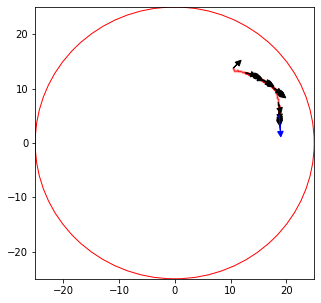

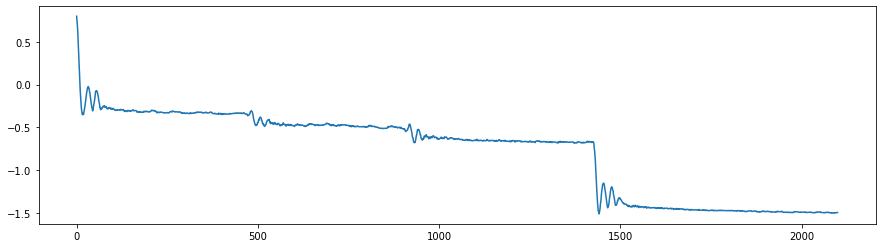

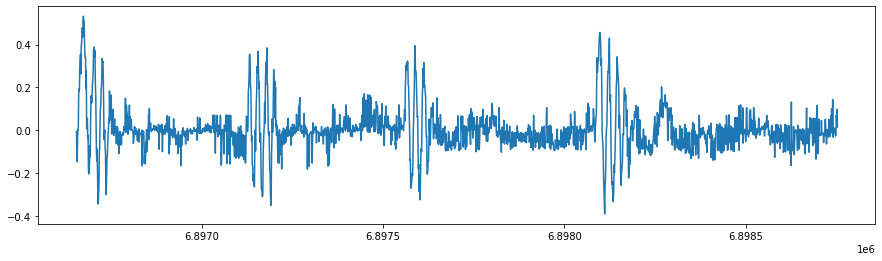

In [103]:
# We should find Positive tail angle => Negative body rotation (turn to the right)

df=pd.DataFrame(np.vstack((x_blob,y_blob,body_angle)).T, 
columns=['x','y','angle'])
id = np.random.randint(df.shape[0])
fig = display_trajectory(df,index = id,past_memory=3*700)

plt.figure(figsize=(15,4))
plt.plot(body_angle[id-3*700:id])
plt.figure(figsize=(15,4))
plt.plot(tail_angle_raw.iloc[id-3*700:id,6])
